<a href="https://colab.research.google.com/github/naromu/BananaRipenessMain/blob/main/banana_ripening_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Banana ripening classifier by naromu and david**



#**This code clones the repository from the dataset**



In [ ]:
# Clone the repository
!git clone https://github.com/Davix002/BananaRipenessDataset.git

# The path of the dataset in the colab folder is defined.
dataset_directory = "/content/BananaRipenessDataset/dataset"

Cloning into 'BananaRipenessDataset'...
remote: Enumerating objects: 833, done.
remote: Counting objects: 100% (380/380), done.
remote: Compressing objects: 100% (370/370), done.
remote: Total 833 (delta 5), reused 378 (delta 4), pack-reused 453
Receiving objects: 100% (833/833), 303.27 MiB | 30.46 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Updating files: 100% (799/799), done.


#**Drive connection**


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#**The libraries and modules necessary for the creation of the model are imported.**



In [ ]:
!pip install tensorflow tensorflow-addons > /dev/null
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.resnet_v2 import preprocess_input as preprocess_resnet
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_densenet
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_mobilenet
from tensorflow.keras.applications.xception import preprocess_input as preprocess_xception
import numpy as np

#**The following code shows me how many files are in each training folder**

In [ ]:
import os

def contar_imagenes(clase):
    num_images = len(os.listdir(f"{dataset_directory}/{clase}"))
    return num_images

clases = ['overripe', 'ripe', 'unripe']
num_images_list = [] 

for clase in clases:
    num_images = contar_imagenes(clase)
    num_images_list.append(num_images)
    print(f"La carpeta {clase} tiene {num_images} imagenes")

La carpeta overripe tiene 258 imagenes
La carpeta ripe tiene 286 imagenes
La carpeta unripe tiene 254 imagenes


#**Show some images of the dataset folders**

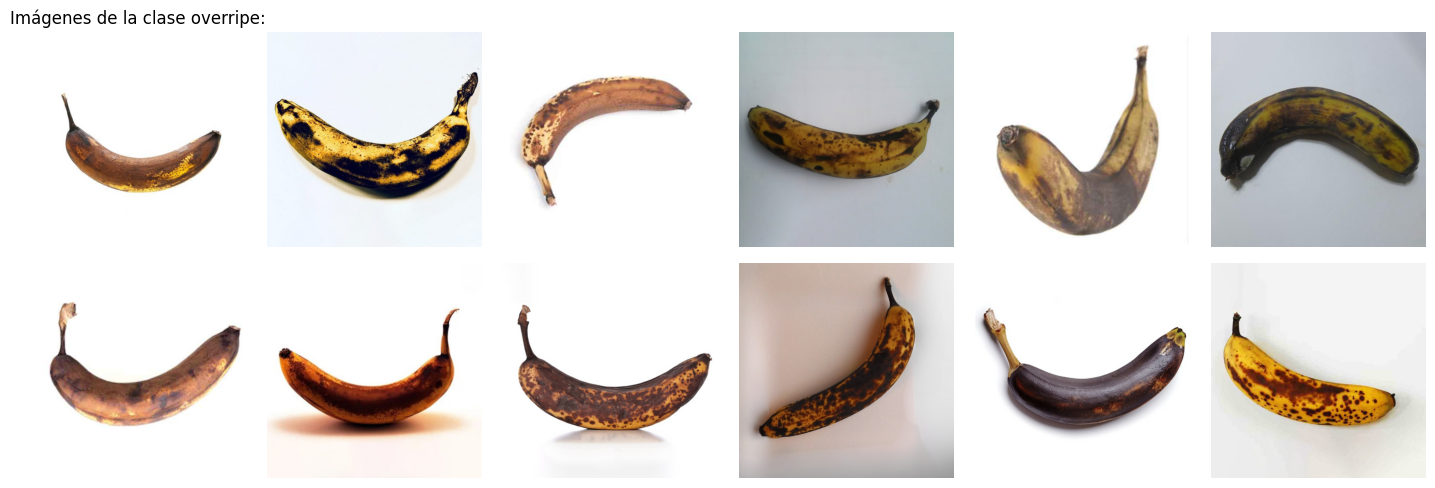

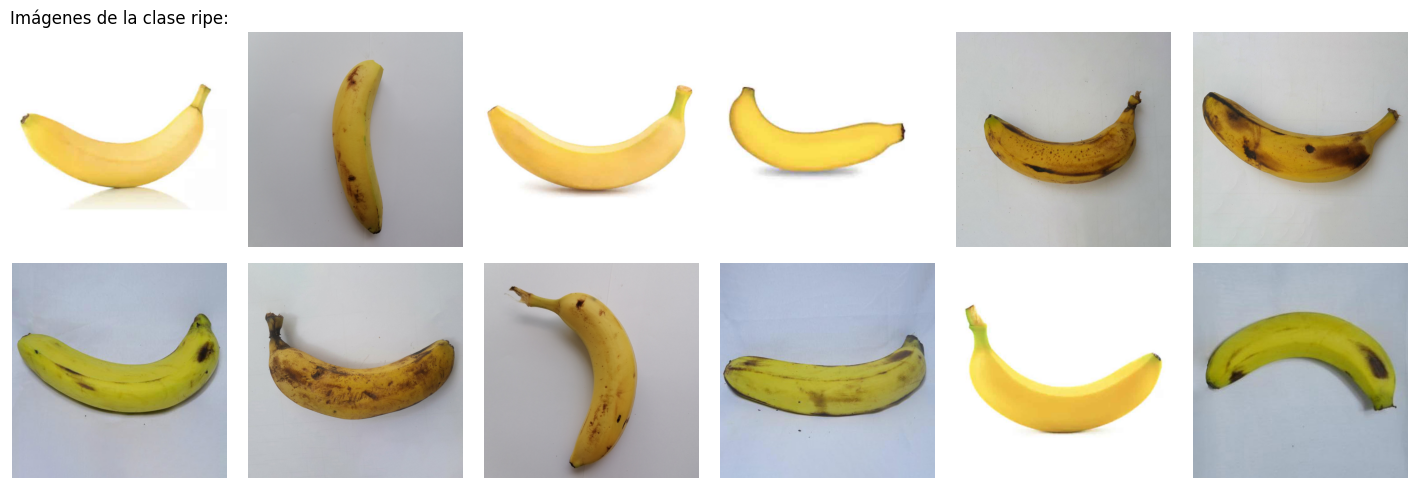

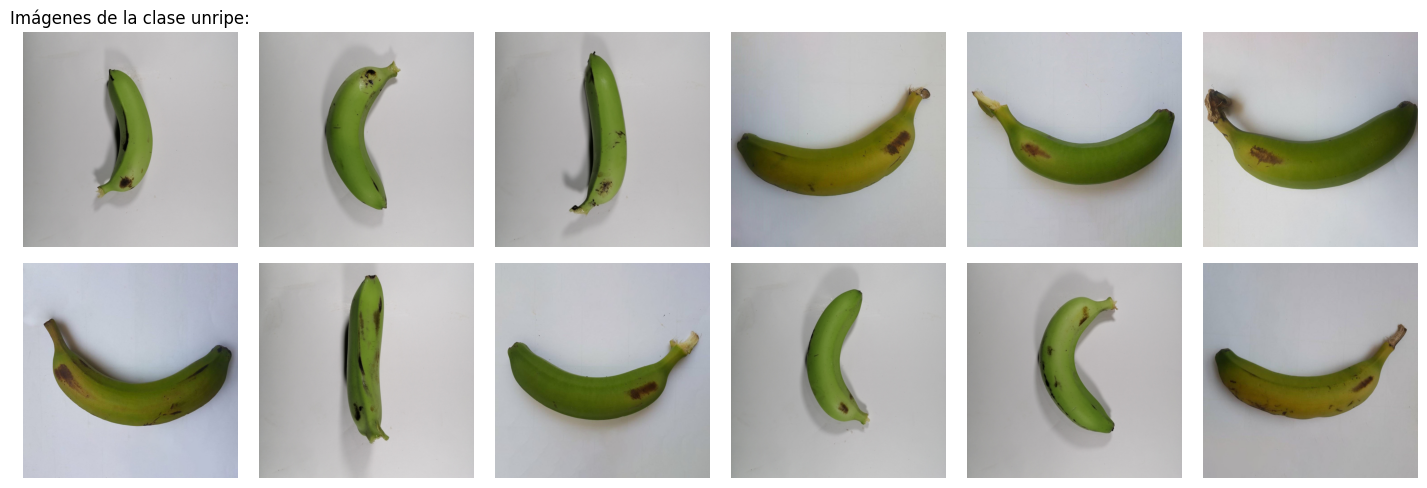

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

def mostrar_imagenes_aleatorias(clase):
    # obtener la lista de nombres de archivos de la clase
    filenames = os.listdir(f"{dataset_directory}/{clase}")

    rows = 2
    cols = 6

    num_imagenes_mostrar = rows * cols  # define aquí el número de imágenes que quieres mostrar

    # seleccionar aleatoriamente 'num_imagenes_mostrar' imágenes
    selected_images = random.sample(filenames, num_imagenes_mostrar)

    fig_width = cols * 3
    fig_height = rows * 3

    fig, axes = plt.subplots(rows, cols, figsize=(fig_width, fig_height))

    for i, image_file in enumerate(selected_images):
        image_path = os.path.join(dataset_directory, clase, image_file)
        img = mpimg.imread(image_path)
        ax = axes[i // cols, i % cols]
        ax.imshow(img)
        ax.axis('off')
        if i == 0:
          ax.set_title(f"Imágenes de la clase {clase}:")  # establece el título del subplot

    # Eliminar los ejes sobrantes si hay menos imágenes que la capacidad de la cuadrícula
    if num_imagenes_mostrar < rows * cols:
        for i in range(num_imagenes_mostrar, rows * cols):
            axes[i // cols, i % cols].axis('off')

    plt.subplots_adjust(wspace=0.1, hspace=0)
    plt.show()

# mostrar imágenes para cada clase
for clase in clases:
    mostrar_imagenes_aleatorias(clase)

#**The following code chooses the folder with the lowest number of images in order to balance all folders with that number**



In [ ]:
min_num_images = min(num_images_list)
print(f"La clase con menor número de imagenes tiene {min_num_images} imágenes")

La clase con menor número de imagenes tiene 254 imágenes


#**This code is for remove extra images**


In [ ]:
import random

# Ruta a la carpeta raíz
root_folder = dataset_directory

# Número objetivo de imágenes
target_count = min_num_images

# Iterar sobre las subcarpetas
for folder in clases:
    # Ruta completa a la subcarpeta
    folder_path = os.path.join(root_folder, folder)
    
    # Obtener la lista de archivos en la subcarpeta
    file_list = os.listdir(folder_path)
    
    # Calcular el número de imágenes a eliminar
    images_to_remove = len(file_list) - target_count
    
    if images_to_remove <= 0:
        continue
    
    # Seleccionar imágenes al azar para eliminar
    images_to_delete = random.sample(file_list, images_to_remove)
    
    # Eliminar las imágenes seleccionadas
    for image in images_to_delete:
        image_path = os.path.join(folder_path, image)
        os.remove(image_path)
        
    print(f"Eliminadas {len(images_to_delete)} imágenes en la carpeta '{folder}'")

Eliminadas 4 imágenes en la carpeta 'overripe'
Eliminadas 32 imágenes en la carpeta 'ripe'


#**This code is to check how many images are left in the training folders**


In [ ]:
for clase in clases:
    num_images = contar_imagenes(clase)
    print(f"La carpeta {clase} tiene {num_images} imagenes")

La carpeta overripe tiene 254 imagenes
La carpeta ripe tiene 254 imagenes
La carpeta unripe tiene 254 imagenes


#**This code is used to split the original dataset into training, validation and test, insert them into dataframes and save them in the content folder**

In [ ]:
import pandas as pd
import os
import glob
import random

folder = dataset_directory
folder_path = os.path.join(folder, "*")
folder_list = glob.glob(folder_path, recursive=True)
n_samples = min_num_images

train_filenames = []
train_labels = []
train_classes = []

val_filenames = []
val_labels = []
val_classes = []

test_filenames = []
test_labels = []
test_classes = []

n_train = int(n_samples * 0.7)  # 70% de las imágenes para entrenamiento
n_val = int(n_samples * 0.15)   # 15% de las imágenes para validación
n_test = int(n_samples * 0.15)  # 15% de las imágenes para pruebas

for label, folder in enumerate(folder_list):
  basename = os.path.basename(folder)
  image_path = os.path.join(folder, "*.jpg")
  filenames = glob.glob(image_path, recursive=True)

  for i in range(5):random.shuffle(filenames)

  for index, filename in enumerate(filenames):
        if index < n_train:
            train_filenames.append(filename)  
            train_labels.append(label)
            train_classes.append(basename)
        elif index < n_train + n_val:
            val_filenames.append(filename)  
            val_labels.append(label)
            val_classes.append(basename)
        else:
            test_filenames.append(filename)  
            test_labels.append(label)
            test_classes.append(basename)

df_train = pd.DataFrame({"filename": train_filenames, "label": train_labels, "class": train_classes})
for i in range(5):
  df_train = df_train.sample(frac=1)

df_val = pd.DataFrame({"filename": val_filenames, "label": val_labels, "class": val_classes})
for i in range(5):
  df_val = df_val.sample(frac=1)

df_test = pd.DataFrame({"filename": test_filenames, "label": test_labels, "class": test_classes})
for i in range(5):
  df_test = df_test.sample(frac=1)

df_train.to_csv("dataset_train.csv", index=False)
df_val.to_csv("dataset_val.csv", index=False)
df_test.to_csv("dataset_test.csv", index=False)

#**Load csv from content directory**

In [ ]:
import pandas as pd

df_train = pd.read_csv("dataset_train.csv")
df_val = pd.read_csv("dataset_val.csv")
df_test = pd.read_csv("dataset_test.csv")

#**Code for save csv dataframes to google drive**

In [ ]:
import os

directory_dataframes = "/content/gdrive/MyDrive/BananaRipenessDataframes"

# Verificar si la carpeta existe, y si no, crearla
if not os.path.exists(directory_dataframes):
    os.makedirs(directory_dataframes)

# Guardar los DataFrames en archivos CSV en el directorio especificado
df_train.to_csv(os.path.join(directory_dataframes, "dataset_train.csv"), index=False)
df_val.to_csv(os.path.join(directory_dataframes, "dataset_val.csv"), index=False)
df_test.to_csv(os.path.join(directory_dataframes, "dataset_test.csv"), index=False)

#**Load csv from google drive**

In [ ]:
import pandas as pd
import os

directory_dataframes = "/content/gdrive/MyDrive/BananaRipenessDataframes"

df_train = pd.read_csv(os.path.join(directory_dataframes, "dataset_train.csv"))
df_val = pd.read_csv(os.path.join(directory_dataframes, "dataset_val.csv"))
df_test = pd.read_csv(os.path.join(directory_dataframes, "dataset_test.csv"))

#**Printout of dataset sizes and class distributions in training, validation and test sets**

In [ ]:
# Print the number of data instances in the training, validation and test set
print("train", len(df_train))
print("val", len(df_val))
print("test", len(df_test))

print()

# Display the count of instances for each class in the training, validation and test set
print(df_train.groupby("class").size(), "\n")
print(df_val.groupby("class").size(), "\n")
print(df_test.groupby("class").size(), "\n")

train 531
val 114
test 117

class
overripe    177
ripe        177
unripe      177
dtype: int64 

class
overripe    38
ripe        38
unripe      38
dtype: int64 

class
overripe    39
ripe        39
unripe      39
dtype: int64 



#**This code verifies that the files are not duplicated in the dataframes**

In [ ]:
# Concatenar todos los DataFrames
all_filenames = pd.concat([df_train["filename"], df_val["filename"], df_test["filename"]])

# Contar los nombres de archivos duplicados
filename_counts = all_filenames.value_counts()

# Verificar si hay algún nombre de archivo que aparezca más de una vez
duplicates = filename_counts[filename_counts > 1]

if len(duplicates) == 0:
    print("No se encontraron nombres de archivo duplicados.")
else:
    print("Se encontraron los siguientes nombres de archivo duplicados:")
    print(duplicates)

No se encontraron nombres de archivo duplicados.


#**The training generator is set up to generate the same augmented data for the 3 models**

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 10,
    zoom_range = [0.6,1.2],
    horizontal_flip = True,
    vertical_flip = True,
    brightness_range = [0.5,1.3],
    )

train_generator=train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=dataset_directory,
    x_col="filename",
    y_col="class",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(224,224))

#**Definition of how many augmented images are desired**

In [ ]:
#Número original de lotes en train_generator
num_original_images = train_generator.samples
desired_augmented_images = num_original_images * 3
#1593 imagenes deseadas

#**The augmented images are saved for transfer to the 3 models**

In [ ]:
directory_augmented_images = "/content/gdrive/MyDrive/BananaRipenessDataAugmentation"

os.makedirs(directory_augmented_images, exist_ok=True)

# obtener el diccionario de indices de clase
class_indices = train_generator.class_indices

# obtener la lista de nombres de clase
class_names = list(class_indices.keys())

# obtener la lista de índices de clase
class_values = list(class_indices.values())

# Asumiendo que las etiquetas están en y_batch y son strings
for i, (x_batch, y_batch) in enumerate(train_generator):
    for j in range(x_batch.shape[0]):
        # obtener la imagen del lote
        image = x_batch[j] 
        # desnormalizar la imagen (ImageDataGenerator la normaliza)
        image = image * 255 
        # convertir a enteros (para guardar como imagen jpg o png)
        image = image.astype('uint8') 

        # obtener el índice de la etiqueta de la imagen (el máximo en la codificación one-hot)
        label_index = np.argmax(y_batch[j])

        # encontrar el índice del valor de etiqueta en la lista de valores de clase
        index_in_class_values = class_values.index(label_index)

        # obtener el nombre de la clase correspondiente
        label = class_names[index_in_class_values]

        # Crear un subdirectorio para esta etiqueta si no existe
        label_dir = os.path.join(directory_augmented_images, label)
        os.makedirs(label_dir, exist_ok=True)

        # Crear un nombre de archivo único
        filename = f"{label_dir}/image_{i}_{j}.jpg"

        # Guardar la imagen en el disco
        tf.keras.preprocessing.image.save_img(filename, image)

    # Detener el loop cuando supere las imagenes deseadas
    if i * j >= desired_augmented_images:
        break

#**This code prints some images of the augmented images**

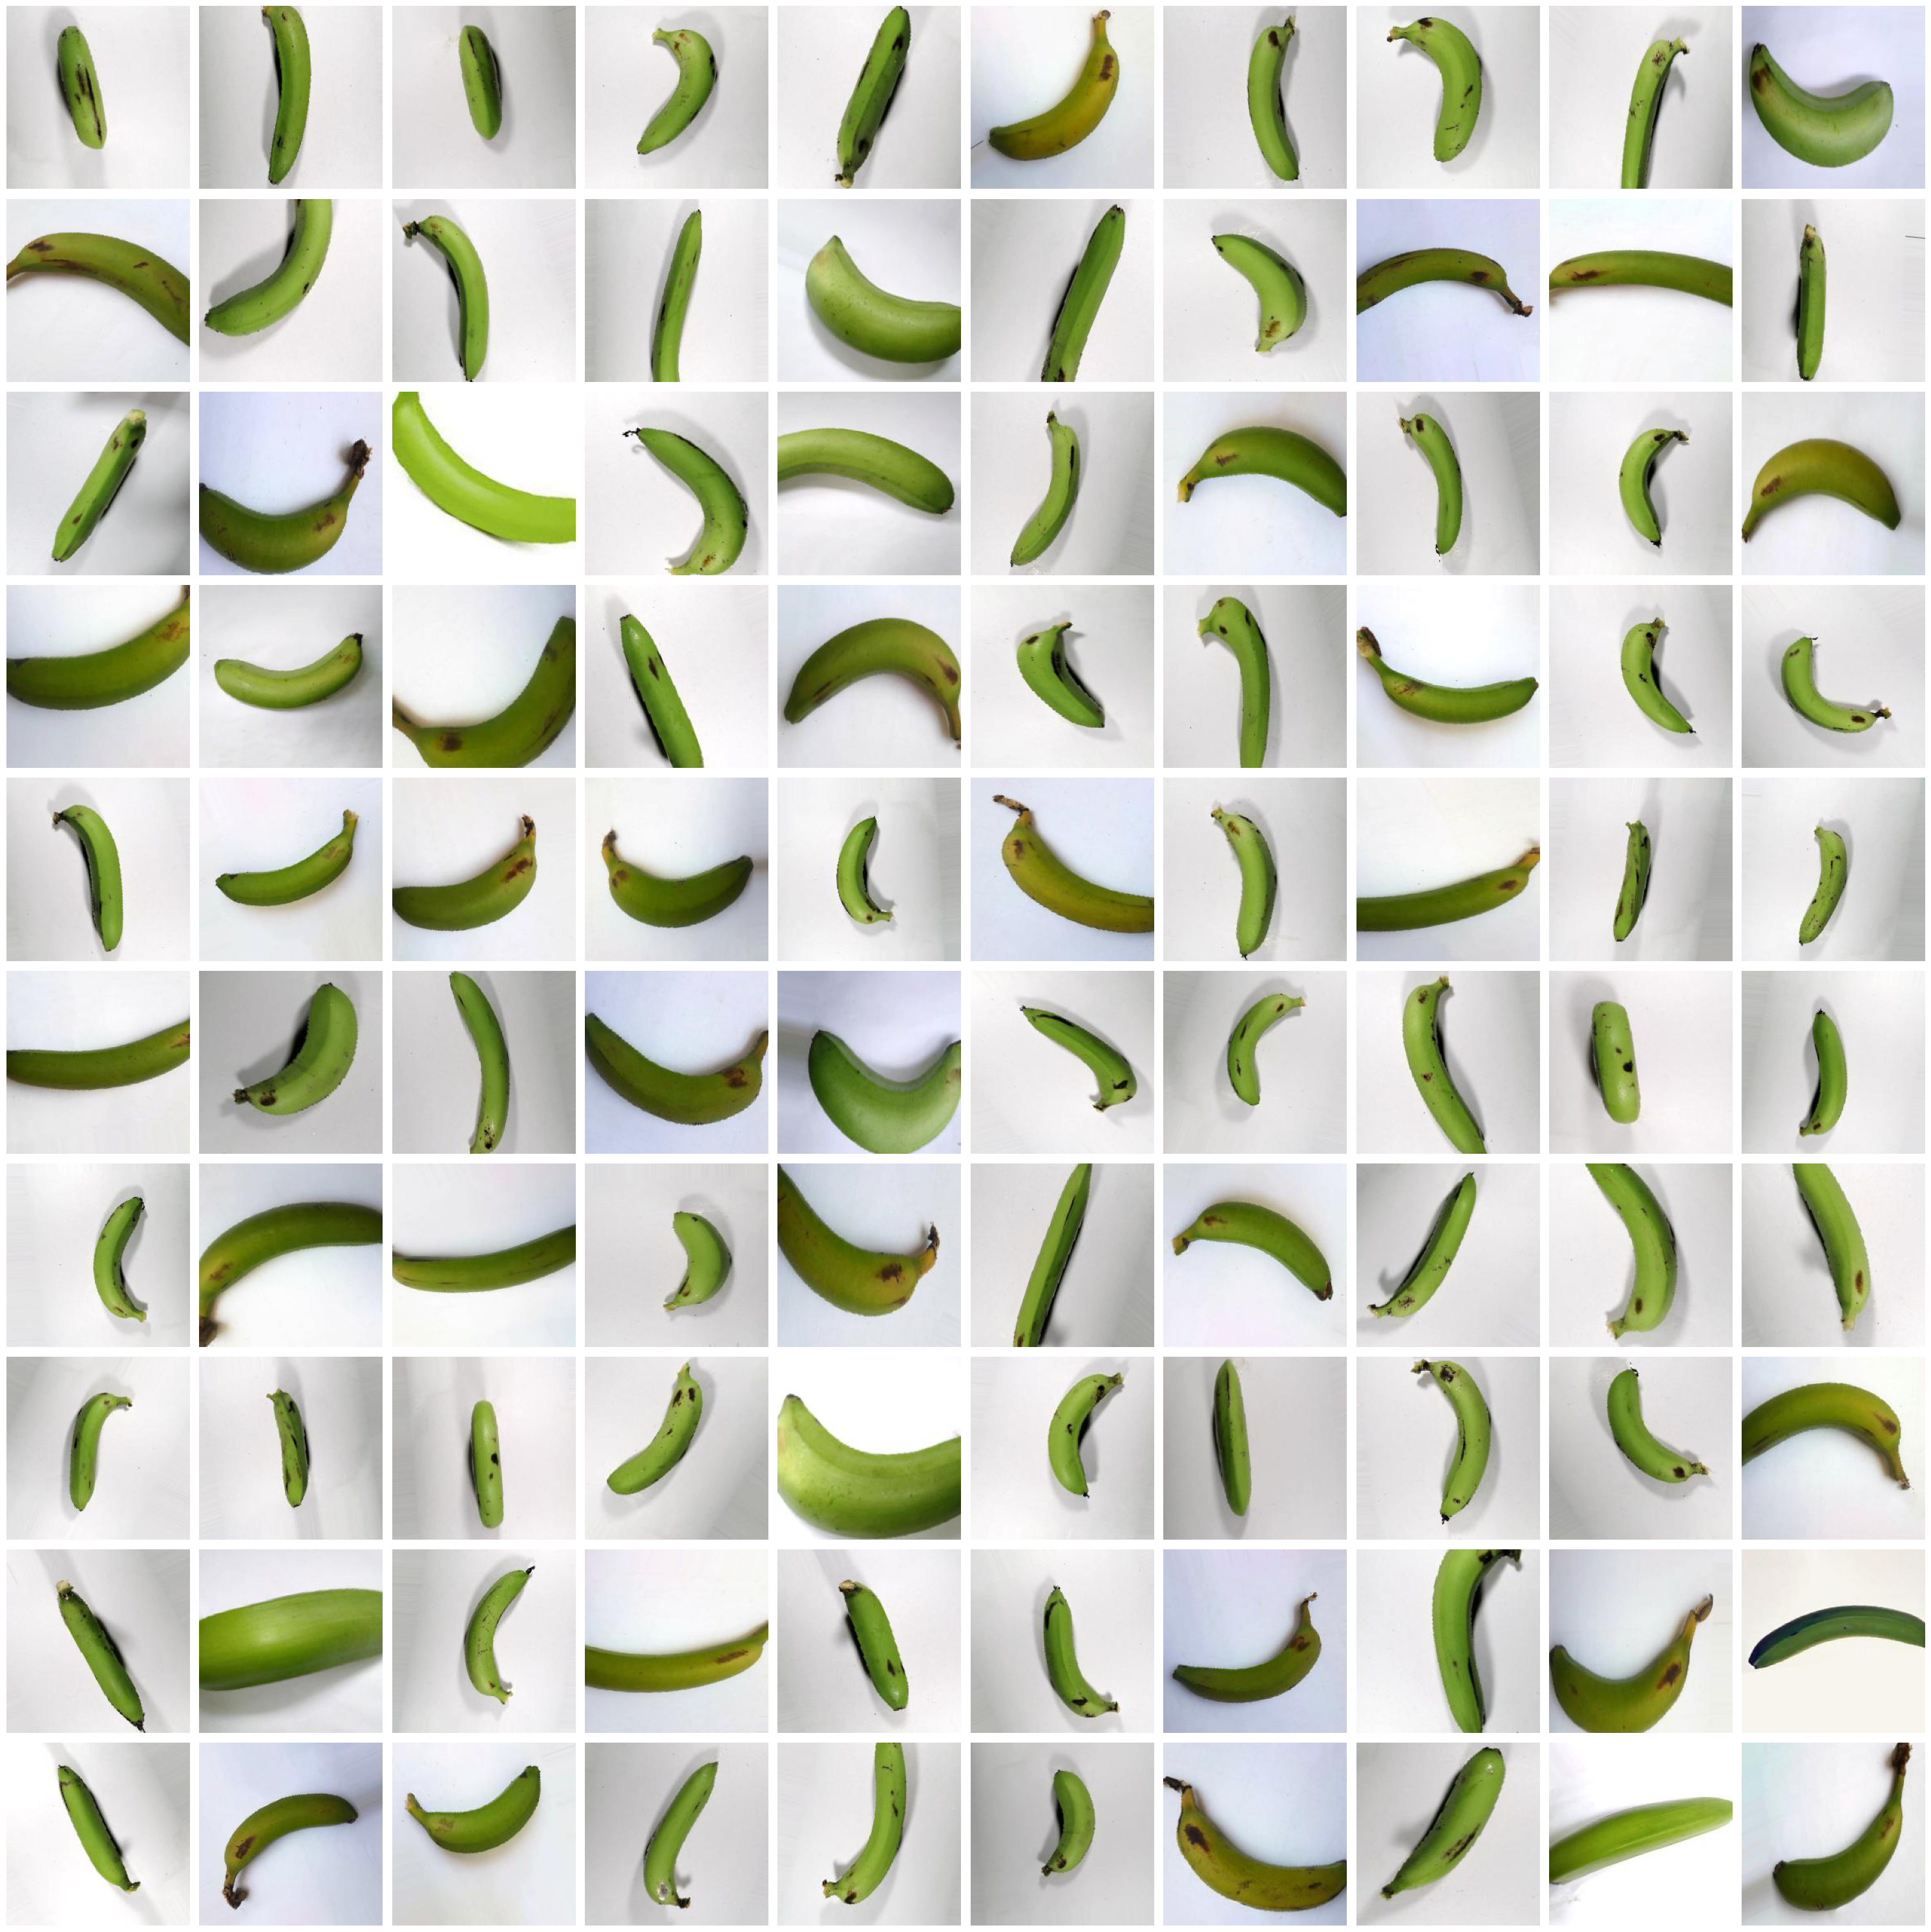

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import random

# Solicitar al usuario que ingrese el índice deseado
start_index = random.randint(0, num_images-10)

rows = 10
cols = 10

num_imagenes_mostrar = rows * cols

fig_width = cols * 3
fig_height = rows * 3

fig, axes = plt.subplots(rows, cols, figsize=(fig_width, fig_height))

axes = axes.flatten()

for i in range(start_index, start_index + num_imagenes_mostrar):
    image_path = images_list[i]
    image = Image.open(image_path)
    
    axes[i - start_index].imshow(image)
    axes[i - start_index].axis("off")

plt.tight_layout()
plt.show()

#**Function to freeze the layers of base model**

In [ ]:
def freeze(model):
  layers_to_freeze = int(len(model.layers) * 0.5)

  for layer in model.layers[:layers_to_freeze]:
    layer.trainable = False

#**Function for Load and save chekpoints**

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import glob
import re

def load_latest_checkpoint(model, model_name):
    # Obtener la lista de todos los archivos de checkpoint para el modelo
    drive_dir = "/content/gdrive/MyDrive/Model_Checkpoints"
    checkpoint_files = glob.glob(os.path.join(drive_dir, f"{model_name}_checkpoint_epoca_*.h5"))

    # Ordenar los archivos por fecha de modificación y tomar el más reciente
    latest_checkpoint_filepath = max(checkpoint_files, key=os.path.getmtime) if checkpoint_files else None
    latest_epoch = 0  # Por defecto, asumir que no hay ninguna época guardada aún
    if latest_checkpoint_filepath:
        print(f"Cargando los pesos del checkpoint para {model_name}: {latest_checkpoint_filepath}")
        model.load_weights(latest_checkpoint_filepath)
        latest_epoch = int(re.search(r"epoca_(\d+)", latest_checkpoint_filepath).group(1))  # Extraer el número de la última época
    else:
        print(f"No se encontró ningún checkpoint para {model_name}.")

    checkpoint_filepath = os.path.join(drive_dir, f"{model_name}_checkpoint_epoca_{{epoch:04d}}.h5")
    checkpoint_cb = ModelCheckpoint(checkpoint_filepath, save_best_only=True, verbose=1)

    return checkpoint_cb, latest_epoch


#**Training function is defined**

In [ ]:
def train_model(model, model_name, train_generator, validation_generator, epocas):
    # Cargar el checkpoint y obtener el callback
    checkpoint_cb, latest_epoch = load_latest_checkpoint(model, model_name)
    # Detener el entrenamiento si no hay mejora en val_loss durante 20 épocas
    early_stopping_cb = EarlyStopping(monitor='val_loss', patience=20)

    print(f"\nIniciando el entrenamiento para {model_name} desde la época {latest_epoch}...")

    history = model.fit(
        train_generator,
        epochs=epocas,
        validation_data=validation_generator,
        callbacks=[checkpoint_cb, early_stopping_cb],
        initial_epoch=latest_epoch,
        verbose=1)

    print(f"Entrenamiento para {model_name} completado\n")
    
    return history

#**Augmented images are loaded and processed to the train, valid and test generator for model Xception**

In [ ]:
directory_augmented_images = "/content/gdrive/MyDrive/BananaRipenessDataAugmentation"

train_xception_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_xception,
)

train_xception_generator = train_xception_datagen.flow_from_directory(
    directory_augmented_images,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_xception_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_xception,
)

valid_xception_generator=val_xception_datagen.flow_from_dataframe(
    dataframe=df_val,
    directory=dataset_directory,
    x_col="filename",
    y_col="class",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(224,224))

test_xception_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_xception,
)

test_xception_generator=test_xception_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=dataset_directory,
    x_col="filename",
    y_col="class",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(224,224))

Found 1657 images belonging to 3 classes.
Found 114 validated image filenames belonging to 3 classes.
Found 117 validated image filenames belonging to 3 classes.


#**Construction and compile of Xception transfer learning model**

In [ ]:
from tensorflow.keras.applications import Xception

model_xception = tf.keras.Sequential([
    Xception(
        include_top=False,
        weights='imagenet',
        input_tensor=None,
        input_shape=(224, 224, 3),
        pooling='avg',),  # Esto es para utilizar el promedio global de pooling al final del modelo
    layers.Dense(3, activation='softmax')  # 3 clases para los 3 niveles de madurez
])

freeze(model_xception.layers[0])

model_xception.summary()

model_xception.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])

83683744/83683744 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense (Dense)               (None, 3)                 6147      
                                                                 
Total params: 20,867,627
Trainable params: 14,864,411
Non-trainable params: 6,003,216
_________________________________________________________________


#**Training model Xception**

In [ ]:
epocas = 50

history_xception = train_model(model_xception, 'model_xception', train_xception_generator, valid_xception_generator, epocas)

No se encontró ningún checkpoint para model_xception.

Iniciando el entrenamiento para model_xception desde la época 0...
Epoch 1/50
52/52 [==============================] - ETA: 0s - loss: 0.2887 - accuracy: 0.9119
Epoch 1: val_loss improved from inf to 0.10098, saving model to /content/gdrive/MyDrive/Model_Checkpoints/model_xception_checkpoint_epoca_0001.h5
52/52 [==============================] - 476s 9s/step - loss: 0.2887 - accuracy: 0.9119 - val_loss: 0.1010 - val_accuracy: 0.9649
Epoch 2/50
52/52 [==============================] - ETA: 0s - loss: 0.0170 - accuracy: 0.9976
Epoch 2: val_loss improved from 0.10098 to 0.05699, saving model to /content/gdrive/MyDrive/Model_Checkpoints/model_xception_checkpoint_epoca_0002.h5
52/52 [==============================] - 18s 352ms/step - loss: 0.0170 - accuracy: 0.9976 - val_loss: 0.0570 - val_accuracy: 0.9737
Epoch 3/50
52/52 [==============================] - ETA: 0s - loss: 0.0073 - accuracy: 0.9988
Epoch 3: val_loss improved from 0.0569

#**Code to save xception model and history to drive**

In [ ]:
import os
import json

path = "/content/gdrive/MyDrive/BananaRipenessModel/ModelBananaRipenessClassification_"

model_xception.save(path + 'xception' + ".h5")

directory = "/content/gdrive/MyDrive/BananaRipenessModel/"

path = os.path.join(directory, "BananaRipenessHistory_xception.json")

history_json = json.dumps(history_xception.history)
with open(path, 'w') as json_file:
    json_file.write(history_json)

#**Augmented images are loaded and processed to the train, valid and test generator for model MobileNetV2**

In [ ]:
directory_augmented_images = "/content/gdrive/MyDrive/BananaRipenessDataAugmentation"

train_mobilenet_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_mobilenet,
)

train_mobilenet_generator = train_mobilenet_datagen.flow_from_directory(
    directory_augmented_images,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_mobilenet_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_mobilenet,
)

valid_mobilenet_generator=val_mobilenet_datagen.flow_from_dataframe(
    dataframe=df_val,
    directory=dataset_directory,
    x_col="filename",
    y_col="class",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(224,224))

test_mobilenet_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_mobilenet,
)

test_mobilenet_generator=test_mobilenet_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=dataset_directory,
    x_col="filename",
    y_col="class",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(224,224))

Found 1657 images belonging to 3 classes.
Found 114 validated image filenames belonging to 3 classes.
Found 117 validated image filenames belonging to 3 classes.


#**Construction and compile of MobileNetv2 transfer learning model**

In [ ]:
from tensorflow.keras.applications import MobileNetV2

model_mobilenetv2 = tf.keras.Sequential([
      MobileNetV2(
                    include_top=False,
                    weights='imagenet',
                    input_tensor=None,
                    input_shape=(224, 224, 3),
                    pooling='avg',),  # Esto es para utilizar el promedio global de pooling al final del modelo
      layers.Dense(3, activation='softmax')  # 3 clases para los 3 niveles de madurez
])

freeze(model_mobilenetv2.layers[0])

model_mobilenetv2.summary()

model_mobilenetv2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])


9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense_1 (Dense)             (None, 3)                 3843      
                                                                 
Total params: 2,261,827
Trainable params: 2,067,331
Non-trainable params: 194,496
_________________________________________________________________


#**Training model mobilenetv2**

In [ ]:
epocas = 50

history_mobilenetv2 =  train_model(model_mobilenetv2, 'model_mobilenetv2', train_mobilenet_generator, valid_mobilenet_generator, epocas)

No se encontró ningún checkpoint para model_mobilenetv2.

Iniciando el entrenamiento para model_mobilenetv2 desde la época 0...
Epoch 1/50
52/52 [==============================] - ETA: 0s - loss: 0.2149 - accuracy: 0.9167
Epoch 1: val_loss improved from inf to 0.15658, saving model to /content/gdrive/MyDrive/Model_Checkpoints/model_mobilenetv2_checkpoint_epoca_0001.h5
52/52 [==============================] - 37s 368ms/step - loss: 0.2149 - accuracy: 0.9167 - val_loss: 0.1566 - val_accuracy: 0.9474
Epoch 2/50
52/52 [==============================] - ETA: 0s - loss: 0.0113 - accuracy: 0.9970
Epoch 2: val_loss improved from 0.15658 to 0.09359, saving model to /content/gdrive/MyDrive/Model_Checkpoints/model_mobilenetv2_checkpoint_epoca_0002.h5
52/52 [==============================] - 11s 218ms/step - loss: 0.0113 - accuracy: 0.9970 - val_loss: 0.0936 - val_accuracy: 0.9825
Epoch 3/50
52/52 [==============================] - ETA: 0s - loss: 0.0037 - accuracy: 0.9994
Epoch 3: val_loss improv

#**Code to save mobilenetv2 model and history to drive**

In [ ]:
import os
import json

path = "/content/gdrive/MyDrive/BananaRipenessModel/ModelBananaRipenessClassification_"

model_mobilenetv2.save(path + 'mobilenetv2' + ".h5")

directory = "/content/gdrive/MyDrive/BananaRipenessModel/"

path = os.path.join(directory, "BananaRipenessHistory_mobilenetv2.json")

history_json = json.dumps(history_mobilenetv2.history)
with open(path, 'w') as json_file:
    json_file.write(history_json)

#**Augmented images are loaded and processed to the train, valid and test generator for model Resnet50v2**

In [ ]:
directory_augmented_images = "/content/gdrive/MyDrive/BananaRipenessDataAugmentation"

train_resnet_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_resnet,
)

train_resnet_generator = train_resnet_datagen.flow_from_directory(
    directory_augmented_images,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_resnet_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_resnet,
)

valid_resnet_generator=val_resnet_datagen.flow_from_dataframe(
    dataframe=df_val,
    directory=dataset_directory,
    x_col="filename",
    y_col="class",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(224,224))

test_resnet_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_resnet,
)

test_resnet_generator=test_resnet_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=dataset_directory,
    x_col="filename",
    y_col="class",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(224,224))

Found 1657 images belonging to 3 classes.
Found 114 validated image filenames belonging to 3 classes.
Found 117 validated image filenames belonging to 3 classes.


#**Construction and compile of ResNet50v2 transfer learning model**

In [ ]:
from tensorflow.keras.applications import ResNet50V2

model_resnet50v2 = tf.keras.Sequential([
    ResNet50V2(
        include_top=False,
        weights='imagenet',
        input_tensor=None,
        input_shape=(224, 224, 3),
        pooling='avg',),  # Esto es para utilizar el promedio global de pooling al final del modelo
    layers.Dense(3, activation='softmax')  # 3 clases para los 3 niveles de madurez
])

freeze(model_resnet50v2.layers[0])

model_resnet50v2.summary()

model_resnet50v2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])

94668760/94668760 [==============================] - 4s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dense_2 (Dense)             (None, 3)                 6147      
                                                                 
Total params: 23,570,947
Trainable params: 21,356,547
Non-trainable params: 2,214,400
_________________________________________________________________


#**Training model resnet50v2**

In [ ]:
epocas = 50

history_resnet = train_model(model_resnet50v2, 'model_resnet50v2', train_resnet_generator, valid_resnet_generator, epocas)

No se encontró ningún checkpoint para model_resnet50v2.

Iniciando el entrenamiento para model_resnet50v2 desde la época 0...
Epoch 1/50
52/52 [==============================] - ETA: 0s - loss: 0.2198 - accuracy: 0.9161
Epoch 1: val_loss improved from inf to 0.39890, saving model to /content/gdrive/MyDrive/Model_Checkpoints/model_resnet50v2_checkpoint_epoca_0001.h5
52/52 [==============================] - 40s 398ms/step - loss: 0.2198 - accuracy: 0.9161 - val_loss: 0.3989 - val_accuracy: 0.8860
Epoch 2/50
52/52 [==============================] - ETA: 0s - loss: 0.0133 - accuracy: 0.9976
Epoch 2: val_loss improved from 0.39890 to 0.20950, saving model to /content/gdrive/MyDrive/Model_Checkpoints/model_resnet50v2_checkpoint_epoca_0002.h5
52/52 [==============================] - 16s 301ms/step - loss: 0.0133 - accuracy: 0.9976 - val_loss: 0.2095 - val_accuracy: 0.9474
Epoch 3/50
52/52 [==============================] - ETA: 0s - loss: 0.0108 - accuracy: 0.9964
Epoch 3: val_loss improved f

#**Code to save resnet50v2 model and history to drive**

In [ ]:
import os
import json

path = "/content/gdrive/MyDrive/BananaRipenessModel/ModelBananaRipenessClassification_"

model_resnet50v2.save(path + 'resnet' + ".h5")

directory = "/content/gdrive/MyDrive/BananaRipenessModel/"

path = os.path.join(directory, "BananaRipenessHistory_resnet.json")

history_json = json.dumps(history_resnet.history)
with open(path, 'w') as json_file:
    json_file.write(history_json)

#**Augmented images are loaded and processed to the train, valid and test generator for model Densenet**

In [ ]:
directory_augmented_images = "/content/gdrive/MyDrive/BananaRipenessDataAugmentation"

train_densenet_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_densenet,
)

train_densenet_generator = train_densenet_datagen.flow_from_directory(
    directory_augmented_images,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_densenet_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_densenet,
)

valid_densenet_generator=val_densenet_datagen.flow_from_dataframe(
    dataframe=df_val,
    directory=dataset_directory,
    x_col="filename",
    y_col="class",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(224,224))

test_densenet_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_densenet,
)

test_densenet_generator=test_densenet_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=dataset_directory,
    x_col="filename",
    y_col="class",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(224,224))

Found 1657 images belonging to 3 classes.
Found 114 validated image filenames belonging to 3 classes.
Found 117 validated image filenames belonging to 3 classes.


In [ ]:
#borrar esto si lo otro funciona
"""directory_augmented_images = "/content/gdrive/MyDrive/BananaRipenessDataAugmentation"

# Crear un nuevo ImageDataGenerator para las imágenes aumentadas guardadas
augmented_datagen = ImageDataGenerator(rescale=1./255) 

# Crear un nuevo generador para las imágenes aumentadas guardadas
augmented_data_saved_generator = augmented_datagen.flow_from_directory(
    directory_augmented_images, # directorio donde se guardaron las imágenes aumentadas
    target_size=(224, 224), # tamaño de las imágenes a las que se cambiará el tamaño
    batch_size=32,
    class_mode='categorical', # esto debe coincidir con cómo se etiquetaron las imágenes
    shuffle=True,
    seed=42
)

val_datagen = ImageDataGenerator(rescale=1./255)

valid_generator=val_datagen.flow_from_dataframe(
    dataframe=df_val,
    directory=dataset_directory,
    x_col="filename",
    y_col="class",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(224,224))

test_datagen = ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=dataset_directory,
    x_col="filename",
    y_col="class",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(224,224))
"""

'directory_augmented_images = "/content/gdrive/MyDrive/BananaRipenessDataAugmentation"\n\n# Crear un nuevo ImageDataGenerator para las imágenes aumentadas guardadas\naugmented_datagen = ImageDataGenerator(rescale=1./255) \n\n# Crear un nuevo generador para las imágenes aumentadas guardadas\naugmented_data_saved_generator = augmented_datagen.flow_from_directory(\n    directory_augmented_images, # directorio donde se guardaron las imágenes aumentadas\n    target_size=(224, 224), # tamaño de las imágenes a las que se cambiará el tamaño\n    batch_size=32,\n    class_mode=\'categorical\', # esto debe coincidir con cómo se etiquetaron las imágenes\n    shuffle=True,\n    seed=42\n)\n\nval_datagen = ImageDataGenerator(rescale=1./255)\n\nvalid_generator=val_datagen.flow_from_dataframe(\n    dataframe=df_val,\n    directory=dataset_directory,\n    x_col="filename",\n    y_col="class",\n    batch_size=32,\n    seed=42,\n    shuffle=True,\n    class_mode="categorical",\n    target_size=(224,224)

#**Construction and compile of DenseNet121 transfer learning model**


In [ ]:
from tensorflow.keras.applications import DenseNet121

model_densenet121 = tf.keras.Sequential([
    DenseNet121(
        include_top=False,
        weights='imagenet',
        input_tensor=None,
        input_shape=(224, 224, 3),
        pooling='avg',),  # Esto es para utilizar el promedio global de pooling al final del modelo
    layers.Dense(3, activation='softmax')  # 3 clases para los 3 niveles de madurez
])

freeze(model_densenet121.layers[0])

model_densenet121.summary()

model_densenet121.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 1024)              7037504   
                                                                 
 dense_4 (Dense)             (None, 3)                 3075      
                                                                 
Total params: 7,040,579
Trainable params: 4,561,219
Non-trainable params: 2,479,360
_________________________________________________________________


#**Training model densenet121**

In [ ]:
epocas = 50

history_densenet = train_model(model_densenet121, 'model_densenet121', train_densenet_generator, valid_densenet_generator, epocas)

No se encontró ningún checkpoint para model_densenet121.

Iniciando el entrenamiento para model_densenet121 desde la época 0...
Epoch 1/50
52/52 [==============================] - ETA: 0s - loss: 0.1704 - accuracy: 0.9312
Epoch 1: val_loss improved from inf to 0.07480, saving model to /content/gdrive/MyDrive/Model_Checkpoints/model_densenet121_checkpoint_epoca_0001.h5
52/52 [==============================] - 55s 355ms/step - loss: 0.1704 - accuracy: 0.9312 - val_loss: 0.0748 - val_accuracy: 0.9561
Epoch 2/50
52/52 [==============================] - ETA: 0s - loss: 0.0061 - accuracy: 0.9994
Epoch 2: val_loss did not improve from 0.07480
52/52 [==============================] - 14s 268ms/step - loss: 0.0061 - accuracy: 0.9994 - val_loss: 0.1239 - val_accuracy: 0.9561
Epoch 3/50
52/52 [==============================] - ETA: 0s - loss: 0.0030 - accuracy: 1.0000
Epoch 3: val_loss improved from 0.07480 to 0.05550, saving model to /content/gdrive/MyDrive/Model_Checkpoints/model_densenet121_ch

#**Code to save densenet model and history to drive**

In [ ]:
import os
import json

path = "/content/gdrive/MyDrive/BananaRipenessModel/ModelBananaRipenessClassification_"

model_densenet121.save(path + 'densenet' + ".h5")

directory = "/content/gdrive/MyDrive/BananaRipenessModel/"

path = os.path.join(directory, "BananaRipenessHistory_densenet.json")

history_json = json.dumps(history_densenet.history)
with open(path, 'w') as json_file:
    json_file.write(history_json)

#**The function for graphing the training is defined**

In [ ]:
import matplotlib.pyplot as plt

def plotear(history,model_name):
  
  plt.figure(figsize=(12, 4))

  plt.subplot(1, 2, 1)
  plt.plot(history['history']['loss'], label='Train Loss')
  plt.plot(history['history']['val_loss'], label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.suptitle(model_name)
  plt.title('Loss Evolution')
  
  plt.subplot(1, 2, 2)
  plt.plot(history['history']['accuracy'], label='Train Accuracy')
  plt.plot(history['history']['val_accuracy'], label='Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.title('Accuracy Evolution')
  plt.savefig(f"loss_and_accuracy_{model_name}.png")
  plt.show()

#**Code to load models from google drive**

In [ ]:
import os
from tensorflow.keras.models import load_model

path = "/content/gdrive/MyDrive/BananaRipenessModel/"
models = {}

# Lista todos los archivos en el directorio de Google Drive
model_files = os.listdir(path)

# Itera sobre todos los archivos
for model_file in model_files:
    # Comprueba si el archivo es un modelo h5
    if model_file.endswith(".h5"):
        # Extrae el nombre del modelo del nombre del archivo
        model_name = model_file.replace("ModelBananaRipenessClassification_", "").replace(".h5", "")
        # Carga el modelo y lo agrega al diccionario
        models[model_name] = {
            'model': load_model(path + model_file)
        }


In [ ]:
import pprint

pprint.pprint(models)

{'densenet121': {'model': <keras.engine.sequential.Sequential object at 0x7f1fac0263e0>},
 'mobilenetv2': {'model': <keras.engine.sequential.Sequential object at 0x7f1face58c10>},
 'resnet': {'model': <keras.engine.sequential.Sequential object at 0x7f1f10e60160>},
 'xception': {'model': <keras.engine.sequential.Sequential object at 0x7f1f91d10580>}}


#**Code to load history**

In [ ]:
import os
import json

path = "/content/gdrive/MyDrive/BananaRipenessModel/"
histories = {}

# Lista todos los archivos en el directorio de Google Drive
history_files = os.listdir(path)

# Itera sobre todos los archivos
for history_file in history_files:
    # Comprueba si el archivo es un archivo json
    if history_file.endswith(".json"):
        history_name = history_file.replace("BananaRipenessHistory_", "").replace(".json", "")
        # Carga el contenido del archivo JSON y lo agrega al diccionario
        with open(os.path.join(path, history_file), 'r') as f:
            history_data = json.load(f)
        histories[history_name] = {
            'history': history_data
        }


In [ ]:
import pprint

pprint.pprint(histories)

#**Plot of training evolution functions**

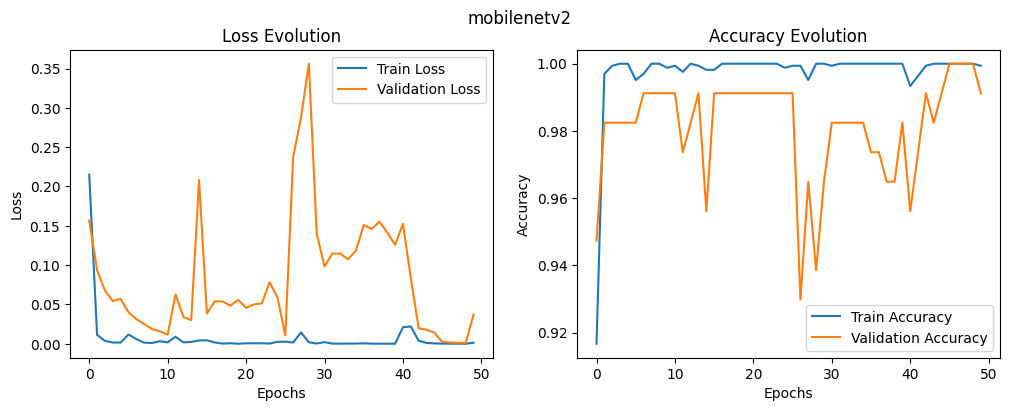

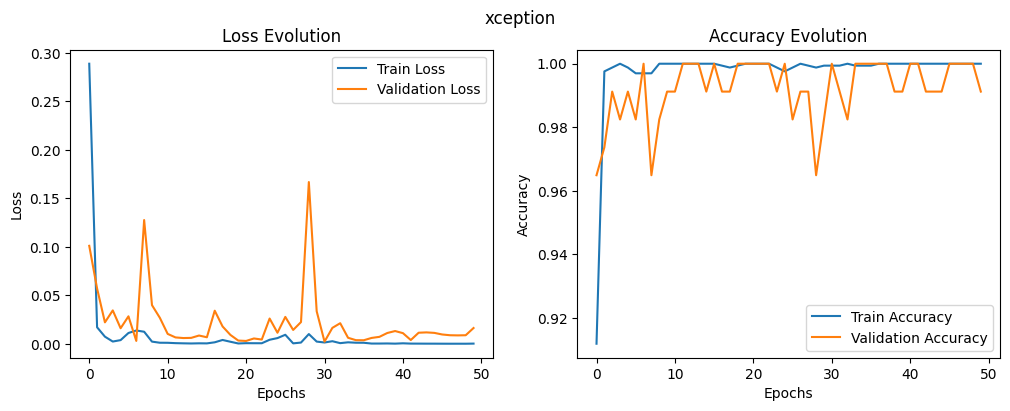

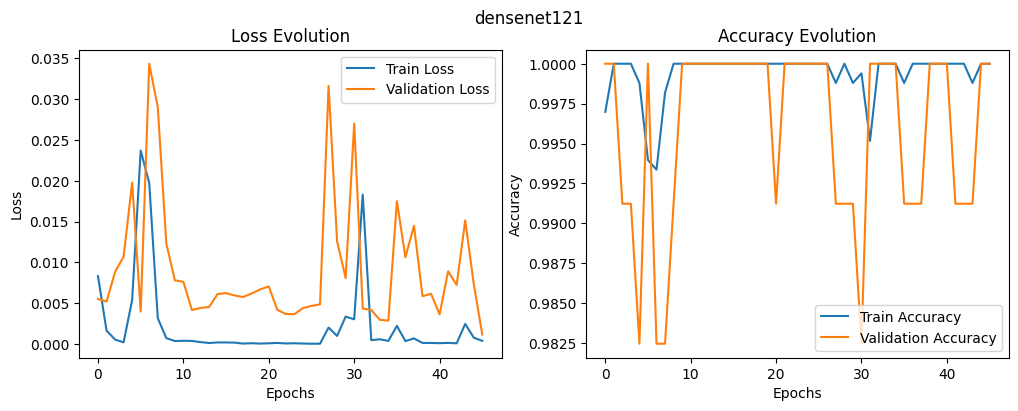

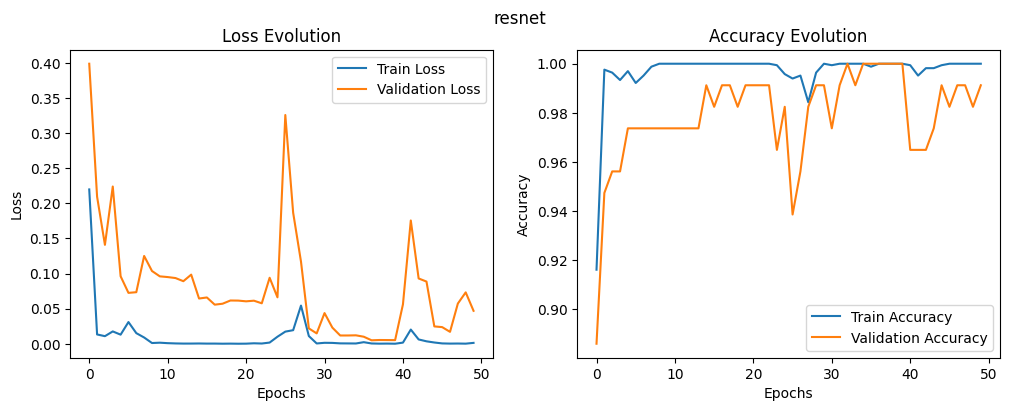

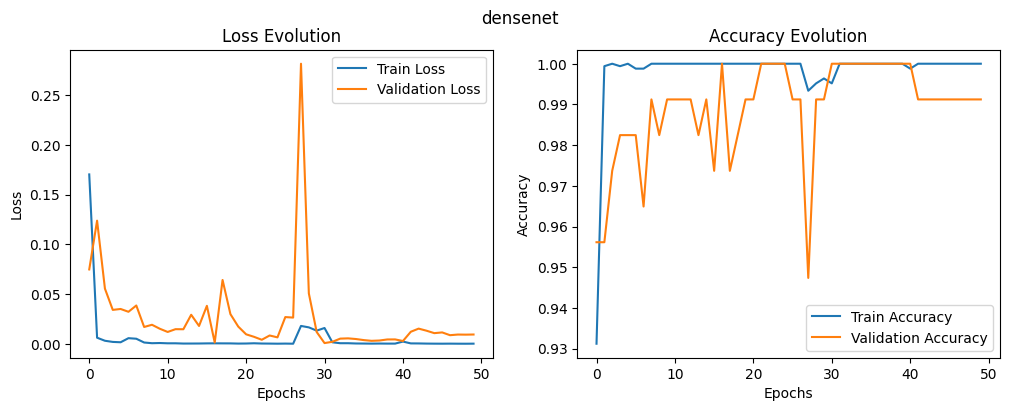

In [ ]:
for name, history in histories.items():
  plotear(history, name)

#**Code to evaluate the models**

In [ ]:
generators = {
    'densenet121': test_densenet_generator,
    'mobilenetv2': test_mobilenet_generator,
    'xception': test_xception_generator,
    'resnet': test_resnet_generator
}

for model_name, model_data in models.items():
    print(f"Evaluando el modelo {model_name}...")
    model = model_data['model']
    generator = generators[model_name]
    score = model.evaluate(generator, verbose=1)
    print(f"Resultados del modelo {model_name}:")
    print(f"Perdida (Loss): {score[0]}")
    print(f"Exactitud (Accuracy): {score[1]}\n")


Evaluando el modelo mobilenetv2...
4/4 [==============================] - 14s 1s/step - loss: 0.0336 - accuracy: 0.9829
Resultados del modelo mobilenetv2:
Perdida (Loss): 0.03356974571943283
Exactitud (Accuracy): 0.9829059839248657

Evaluando el modelo densenet121...
4/4 [==============================] - 10s 1s/step - loss: 0.0634 - accuracy: 0.9829
Resultados del modelo densenet121:
Perdida (Loss): 0.06344565749168396
Exactitud (Accuracy): 0.9829059839248657

Evaluando el modelo xception...
4/4 [==============================] - 9s 1s/step - loss: 0.0232 - accuracy: 0.9915
Resultados del modelo xception:
Perdida (Loss): 0.023206811398267746
Exactitud (Accuracy): 0.9914529919624329

Evaluando el modelo resnet...
4/4 [==============================] - 7s 1s/step - loss: 0.0293 - accuracy: 0.9915
Resultados del modelo resnet:
Perdida (Loss): 0.029264254495501518
Exactitud (Accuracy): 0.9914529919624329



#**Definition of the prediction voting function**

In [ ]:
def majority_voting(models):
    num_classes = 3
    votes = np.zeros(num_classes)
    confidence = np.zeros(num_classes)

    for model_name, model_data in models.items():
        prediction = model_data['prediction']
        class_prediction = model_data['class_prediction']
        confidence_score = model_data['confidence_score']
        print(f"Modelo: {model_name}\t=>\tpredicción: {prediction} - {class_prediction}\t=>\tconfianza: {confidence_score}")
        votes[prediction] += 1
        confidence[prediction] += confidence_score

    if len(set(votes)) == len(votes):
        return np.argmax(confidence)
    else:
        return np.argmax(votes)

#**Code for generalizing predictions**



In [ ]:
from tensorflow.keras.preprocessing import image

img_path = '/content/descarga2.jpg'
img = image.load_img(img_path, target_size=(224, 224))

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0

class_names = ['overripe', 'ripe', 'unripe']

print("\nLos nombres de las clases son:", class_names, "\n")

for model_data in models.values():
    prediction_scores = model_data['model'].predict(x)[0]
    prediction = np.argmax(prediction_scores)
    model_data['prediction']= prediction
    model_data['class_prediction'] = class_names[prediction]
    model_data['confidence_score'] = prediction_scores[prediction]

print("\n")
best_prediction = majority_voting(models)

print("\nMejor predicción:", best_prediction)

predicted_class_name = class_names[best_prediction]

print("\nLa clase predicha es:", predicted_class_name)


Los nombres de las clases son: ['overripe', 'ripe', 'unripe'] 

1/1 [==============================] - 0s 44ms/step


Modelo: mobilenetv2	=>	predicción: 2 - unripe	=>	confianza: 1.0
Modelo: resnet50v2	=>	predicción: 2 - unripe	=>	confianza: 0.9621886610984802
Modelo: densenet121	=>	predicción: 2 - unripe	=>	confianza: 1.0

Mejor predicción: 2

La clase predicha es: unripe
